# Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from skimage.color import label2rgb
from skimage.measure import regionprops
from scipy.signal import convolve2d

import os

In [2]:
if not os.path.exists('res'):
    os.mkdir('res')
if not os.path.exists('res/imgs'):
    os.mkdir('res/imgs')
if not os.path.exists('res/frames'):
    os.mkdir('res/frames')
if not os.path.exists('res/videos'):
    os.mkdir('res/videos')
if not os.path.exists('res/frames/all'):
    os.mkdir('res/frames/all')
if not os.path.exists('res/videos/all'):
    os.mkdir('res/videos/all')

# Edge Detection & Connected Components Labelling Functions

In [3]:
def Gauss2D(k_x, sigma_x, k_y, sigma_y):
    # Inputs
    # k_x: filter radius along x direction
    # sigma_x: sigma along x direction
    # k_y: filter radius along y direction
    # sigma_y: sigma along y direction

    # Outputs:
    # Guassian Kernel of size (2*k_x + 1) x (2*k_y + 1)

    # Gaussian kernel along x
    radius_x = k_x
    x = np.arange(-radius_x, radius_x + 1)            # Generate X values between -k_x to k_x+1
    kernel_x = np.exp(- x**2 / (2 * sigma_x**2))      # Gaussian  Exponential portion
    kernel_x = np.reshape(kernel_x, [2*k_x + 1, 1])   # Reshape into Column Vector

    # Gaussian kernel along y
    radius_y = k_y
    y = np.arange(-radius_y, radius_y + 1)            # Generate Y values between -k_y to k_y+1
    kernel_y = np.exp(- y**2 / (2 * sigma_y**2))      # Gaussian Exponential portion
    kernel_y = np.reshape(kernel_y, [2*k_y + 1, 1])   # Reshape into Column Vector

    gaussKernel = np.dot(kernel_x, kernel_y.T)        # Outter product of X and Y Gaussian Vectors
    gaussKernel = gaussKernel / gaussKernel.sum()     # Normalize the kernel
    return gaussKernel 


def gradMagnitude(img):
    # Inputs
    # img: image f(x,y)

    # Outputs:
    # Gradient Magnitude g(x,y)

    # x and y high-pass filters
    filter_x = np.array([[-1,0,1],
                         [-2,0,2],
                         [-1,0,1]])
    filter_y = np.array([[-1,-2,-1],
                         [0 , 0, 0], 
                         [1 , 2, 1]])
    
    # Compute Sobel operators
    g_x = convolve2d(img, filter_x, mode='same') 
    g_y = convolve2d(img, filter_y, mode='same') 

    return np.sqrt(np.square(g_x) + np.square(g_y))


def thresholdAlgorithm(img):
    # Inputs
    # img: image gradient g(x,y)

    # Outputs:
    # edge-mapped image E(x,y), threshold value tau

    # 1. compute initial threshold tau_0 of the image
    tau_0 = img.sum() / (img.shape[0]*img.shape[1])

    # 2. Separate g(x,y) into two classes
    m_H = img * (img > tau_0)               # all entries of image greater than threshold
    m_L = img * (img < tau_0)               # all entries of image smaller than threshold

    # 3. Compute average of mL and mH
    m_H_count = (m_H > 0).sum()
    if m_H_count > 0:
       m_H = m_H.sum() / m_H_count 
    m_L_count = (m_L > 0).sum()
    if m_L_count > 0:
       m_L = m_L.sum() / m_L_count 

    # 4. Update threshold value
    tau_i = (m_L + m_H) / 2

    # 5. Loop while threshold difference above epsilon, small
    tau_test = tau_0
    epi = 1e-4
    i = 0
    while np.absolute(tau_i - tau_test) > epi:
        i += 1
        # 2. Separate g(x,y) into two classes
        tau_test = tau_i
        m_H = img * (img > tau_test)        # all entries of image greater than threshold
        m_L = img * (img < tau_test)        # all entries of image smaller than threshold

        # 3. Compute average of mL and mH
        m_H_count = (m_H > 0).sum()
        if m_H_count > 0:
            m_H = m_H.sum() / m_H_count 
        m_L_count = (m_L > 0).sum()
        if m_L_count > 0:
            m_L = m_L.sum() / m_L_count 
  
        # 4. Update threshold value
        tau_i = (m_L + m_H) / 2

    # print('Loop iterations: ', i)
    # print('Threshold: ', tau_i)
    # Return image gradient where value greater than threshold
    return 1*(img > tau_i), tau_i


def CCL(img):
    # Inputs
    # img: edge-mapped image E(x,y)

    # Outputs:
    # labels: modified image of each connected component labelled

    # Initialize label matrix of size w x h
    x, y = img.shape
    labels = np.zeros([x,y], dtype=int)
    queue = []    # Initialize queue as a list
    
    # 1. Start from first pixel, set current label = 0 as there are none labeled yet
    currLabel = 0
    for i in range(x):
        for j in range(y):
            # 3. pop from queue, look at 8 neighbours
            #       if neighbour is foreground (white), not labelled
            #             give currLabel
            #             add to queue
            # Repeat while queue not empty

            # 2. if pixel is foreground (white) and not labelled, label and add to queue
            #    else, (i.e. background (black) or labelled, next)
            if img[i][j] == 255 and labels[i][j] == 0:
                # print(i, j)
                # 4. increment label as new pixel without label is found
                currLabel += 1
                labels[i][j] = currLabel
                queue.append((i,j))
                # 3. Pop element from queue, label neighbours if foreground, add to queue
                #    loop until queue empty 
                while len(queue) > 0:
                    i_pop, j_pop = queue.pop(0)
                    # loop through all 9 neighbours
                    for i_pop_iter in([-1, 0, 1]):
                        for j_pop_iter in([-1, 0, 1]):
                            # skip if on original pixel
                            if i_pop_iter == 0 and j_pop_iter == 0:
                                pass
                            else:
                                # calculate current position
                                x_pos = i_pop + i_pop_iter
                                y_pos = j_pop + j_pop_iter
                                # skip if current position is corner
                                if (x_pos) < 0 or (y_pos) < 0 or (x_pos) > (x-1) or  (y_pos) > (y-1):    
                                    pass
                                else:
                                    # check if neighbour is foreground (white) and not labelled
                                    if img[x_pos][y_pos] == 255 and labels[x_pos][y_pos] == 0:
                                        # label and add to queue
                                        labels[x_pos][y_pos] = currLabel
                                        queue.append((x_pos,y_pos))
                # # 4. increment label after queue is empty
                # currLabel += 1
    return labels


# Section adapted from https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html
def visualizeCells(label_image, img):
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=img, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # draw rectangle around segmented cells
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig('res/img_CCL.png', cmap='gray')
    plt.show()

# Scatter Inpainting Algorithm

## Functions

In [4]:
def confettiRemoval(coords1,coords2,currLabel):
    # Inputs
    # coords1, coords2: coordinates of the bounding box of area of interest
    # currLabel: current iteration

    # Outputs:
    # augmented image with current area of interest smoothened
    
    # area of interest
    rmin_PAD = coords1[0]
    cmin_PAD = coords1[1]
    rmax_PAD = coords2[0]
    cmax_PAD = coords2[1]
    img_C = img[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]
    img_clr_C = img_clr[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD,:]
    img_grad_C = img_grad[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]
    img_edge_C = img_edge[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]

    # loop
    for ctr in range(CTR):
        
        visited = np.zeros(np.shape(img_edge_C))
        rows, cols = np.where(img_edge_C == 1)
        nodes = []
        for i in range(len(rows)):
            row, col = rows[i], cols[i]
            # only edge pixels not in PADDED area
            if row > minr or col < minc or row > maxr or col < maxc:
                nodes.append((row,col))
            
            if DIR_4PX:
                # up down, left right
                directions = [(-1,0),(1,0),(0,-1),(0,1)]
            else:
                directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
        R = PAD
        while len(nodes) > 0:
            # current edge coords
            row, col = nodes.pop(0)
            # only visit node if not visited before
            if visited[row, col] == 0:
                visited[row, col] = 1
                sum_k = []
                for d in directions:
                    # avoid direction if edge 
                    if img_edge_C[row+d[0]-1, col+d[1]-1] != 255:
                        curr_sum = 0
                        for r in range(R):
                            # calculate current position
                            r_pos = row+d[0]*r
                            c_pos = col+d[1]*r

                            # skip if current position is outside image
                            if (c_pos) < 0 or (r_pos) < 0 or (c_pos) > (img_C.shape[1]-1) or  (r_pos) > (img_C.shape[0]-1):    
                                pass
                            else:
                                curr_sum += np.abs(int(img_grad_C[row,col]) - int(img_grad_C[r_pos,c_pos]))
                        sum_k.append(curr_sum)
                    
                # take max direction and value
                max_d = np.argmax(sum_k)
                best_dir = directions[max_d]
                # replace current pixel value with the new pixel value
                img_C[row,col] = img_C[row+best_dir[0],col+best_dir[1]]
                img_clr_C[row,col,0] = img_clr_C[row+best_dir[0],col+best_dir[1],0]
                img_clr_C[row,col,1] = img_clr_C[row+best_dir[0],col+best_dir[1],1]
                img_clr_C[row,col,2] = img_clr_C[row+best_dir[0],col+best_dir[1],2]

        # update ONLY area of interest (reduces computation)
        img[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD] = img_C
        img_clr[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD,:] = img_clr_C
        
        img_G_update = convolve2d(img_C, gaussFilter, mode='same')
        img_grad_C = gradMagnitude(img_G_update)
        img_edge_C = 1*(img_grad_C > TAU)

        # unshift by padding
        r_left = (minr-rmin_PAD)*(minr != rmin_PAD)
        r_right = (rmax_PAD-maxr)*(maxr != rmax_PAD)
        col_top = (minc-cmin_PAD)*(minc != cmin_PAD)
        col_bot = (cmax_PAD-maxc)*(maxc != cmax_PAD)

        img_grad[minr:maxr,minc:maxc] = img_grad_C[r_left:rmax_PAD-rmin_PAD-r_right,col_top:cmax_PAD-cmin_PAD-col_bot]
        img_edge[minr:maxr,minc:maxc] = img_edge_C[r_left:rmax_PAD-rmin_PAD-r_right,col_top:cmax_PAD-cmin_PAD-col_bot]

        # save current frames
        if PLOT_BOX:
            cv2.imwrite('res/frames/{}/img_clr_C_{}.png'.format(currLabel,ctr),img_clr_C)
            cv2.imwrite('res/frames/{}/img_edge_C_{}.png'.format(currLabel,ctr),255*img_edge_C)

        img_clr_R = img_clr.copy()
        # draw red box
        img_clr_R[rmin_PAD:rmax_PAD,cmin_PAD,2] = 255
        img_clr_R[rmin_PAD:rmax_PAD,cmin_PAD,0:2] = 0
        img_clr_R[rmin_PAD:rmax_PAD-1,cmax_PAD-1,2] = 255
        img_clr_R[rmin_PAD:rmax_PAD-1,cmax_PAD-1,0:2] = 0
        img_clr_R[rmin_PAD,cmin_PAD:cmax_PAD-1,2] = 255
        img_clr_R[rmin_PAD,cmin_PAD:cmax_PAD-1,0:2] = 0
        img_clr_R[rmax_PAD-1,cmin_PAD:cmax_PAD-1,2] = 255
        img_clr_R[rmax_PAD-1,cmin_PAD:cmax_PAD-1,0:2] = 0
        cv2.imwrite('res/frames/all/img_clr_{}.png'.format(currLabel*CTR+ctr),img_clr_R)

        
        img_edge_R = np.zeros((img_edge.shape[0],img_edge.shape[1],3))
        img_edge_R[img_edge == 1,:] = 255
        # draw red box
        img_edge_R[rmin_PAD:rmax_PAD,cmin_PAD,2] = 255
        img_edge_R[rmin_PAD:rmax_PAD,cmin_PAD,0:2] = 0
        img_edge_R[rmin_PAD:rmax_PAD-1,cmax_PAD-1,2] = 255
        img_edge_R[rmin_PAD:rmax_PAD-1,cmax_PAD-1,0:2] = 0
        img_edge_R[rmin_PAD,cmin_PAD:cmax_PAD-1,2] = 255
        img_edge_R[rmin_PAD,cmin_PAD:cmax_PAD-1,0:2] = 0
        img_edge_R[rmax_PAD-1,cmin_PAD:cmax_PAD-1,2] = 255
        img_edge_R[rmax_PAD-1,cmin_PAD:cmax_PAD-1,0:2] = 0
        cv2.imwrite('res/frames/all/img_edge_{}.png'.format(currLabel*CTR+ctr),img_edge_R)


# adapted from https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/
def generateVideos(currLabel):

    # Image
    img_array = []
    for i in range(CTR):
        filename = 'res/frames/{}/img_clr_C_{}.png'.format(currLabel,i)
        img_temp = cv2.imread(filename)
        height, width, layers = img_temp.shape
        size = (width,height)
        img_array.append(img_temp)
    out = cv2.VideoWriter('res/videos/{}/img_clr_C.avi'.format(currLabel),cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

    # Edges
    img_array = []
    for i in range(CTR):
        filename = 'res/frames/{}/img_edge_C_{}.png'.format(currLabel,i)
        img_temp = cv2.imread(filename)
        height, width, layers = img_temp.shape
        size = (width,height)
        img_array.append(img_temp)
    out = cv2.VideoWriter('res/videos/{}/img_edge_C.avi'.format(currLabel),cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()


# adapted from https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/
def generateOverallVideo(numFrames):
    
    # Image
    img_array = []
    for i in range(numFrames):
        filename = 'res/frames/all/img_clr_{}.png'.format(i)
        img_temp = cv2.imread(filename)
        height, width, layers = img_temp.shape
        size = (width,height)
        img_array.append(img_temp)
    out = cv2.VideoWriter('res/videos/all/img_clr.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

    # Edges
    img_array = []
    for i in range(numFrames):
        filename = 'res/frames/all/img_edge_{}.png'.format(i)
        img_temp = cv2.imread(filename)
        height, width, layers = img_temp.shape
        size = (width,height)
        img_array.append(img_temp)
    out = cv2.VideoWriter('res/videos/all/img_edge.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [5]:
def plotFigures(coords1, coords2, currLabel, state):
    rmin_PAD = coords1[0]
    cmin_PAD = coords1[1]
    rmax_PAD = coords2[0]
    cmax_PAD = coords2[1]
    
    img_C = img[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]
    img_clr_C = img_clr[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD,:]
    img_grad_C = img_grad[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]
    img_edge_C = img_edge[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]


    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 10)
    ax1.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax = plt.gca()
    ax1.add_patch(Rectangle((cmin_PAD,rmin_PAD),cmax_PAD-cmin_PAD,rmax_PAD-rmin_PAD,linewidth=1
                     ,edgecolor='r',facecolor='none'))
    ax2.imshow(img_edge, cmap='gray')
    ax2.axis('off')
    ax2.add_patch(Rectangle((cmin_PAD,rmin_PAD),cmax_PAD-cmin_PAD,rmax_PAD-rmin_PAD,linewidth=1
                     ,edgecolor='r',facecolor='none'))
    plt.savefig('res/imgs/{}/img_redbox_{}.png'.format(currLabel,state),
                bbox_inches='tight', pad_inches=1)
    plt.close()


    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(9, 3)
    ax1.imshow(cv2.cvtColor(img_clr_C, cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax2.imshow(img_C, cmap='gray')
    ax2.axis('off')
    ax3.imshow(img_edge_C, cmap='gray')
    ax3.axis('off')
    plt.savefig('res/imgs/{}/img_zoomed_{}.png'.format(currLabel,state),
                bbox_inches='tight', pad_inches=1)
    plt.close()

    cv2.imwrite('res/imgs/{}/img_clr_C_{}.png'.format(currLabel,state),img_clr_C)
    cv2.imwrite('res/imgs/{}/img_edge_C_{}.png'.format(currLabel,state),255*img_edge_C)


## Run

In [6]:
#  ADJUSTABLE PARAMETERS

# LOAD IMAGE - change image file
img = cv2.imread('img0036.png', 0)
img_clr = cv2.imread('img0036.png')

# Gaussian Kernel and sigma
K = 3
SIG = 1

# Image Padding
PAD = 5

# confetti min/max sizes
MIN_SIZE = 5
MAX_SIZE = 50

# direction, either 4 or 8 nearest neighbour: T/F - default: True
DIR_4PX = True

# plot individual bounding box - either T/F, default: False
PLOT_BOX = False

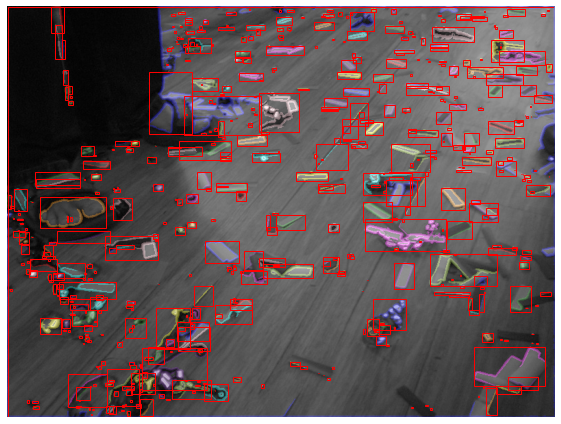

Current Label: 0
(0, 59) (44, 87)
Current Label: 1
(0, 556) (15, 573)
Current Label: 2
(0, 725) (18, 762)
Current Label: 3
(2, 495) (40, 541)
Current Label: 4
(3, 478) (19, 494)
Current Label: 5
(5, 650) (24, 682)
Current Label: 6
(10, 388) (31, 421)
Current Label: 7
(10, 674) (26, 706)
Current Label: 8
(11, 254) (27, 274)
Current Label: 9
(14, 281) (30, 298)
Current Label: 10
(15, 255) (31, 274)
Current Label: 11
(18, 443) (39, 483)
Current Label: 12
(21, 344) (39, 381)
Current Label: 13
(23, 547) (43, 585)
Current Label: 14
(27, 358) (46, 374)
Current Label: 15
(29, 714) (50, 744)
Current Label: 16
(31, 492) (53, 531)
Current Label: 17
(39, 336) (57, 353)
Current Label: 18
(40, 259) (72, 303)
Current Label: 19
(40, 599) (61, 616)
Current Label: 20
(43, 702) (86, 760)
Current Label: 21
(53, 255) (72, 287)
Current Label: 22
(60, 328) (78, 360)
Current Label: 23
(68, 500) (87, 522)
Current Label: 24
(70, 327) (86, 348)
Current Label: 25
(70, 339) (87, 361)
Current Label: 26
(71, 549) (9

In [7]:
# Blur, gradient magnitude, edge detection, and CCL
gaussFilter = Gauss2D(K, SIG, K, SIG)
img_G = convolve2d(img, gaussFilter, mode='same')
img_grad = gradMagnitude(img_G)
img_grad = img_grad/img_grad.max()*255
img_edge, TAU = thresholdAlgorithm(img_grad)
labeledImage = CCL(255*img_edge)
visualizeCells(labeledImage, img)

row, col = labeledImage.shape

# at most radially removed this many pixels
CTR = MAX_SIZE // 2

# Write initial images
cv2.imwrite('res/img_clr_init.png',img_clr)
cv2.imwrite('res/img_edge_init.png',img_edge*255)

currLabel = 0
for region in regionprops(labeledImage):
    # draw rectangle around segmented cells
    minr, minc, maxr, maxc = region.bbox

    # limit size of confetti
    if (maxr-minr) < MAX_SIZE and (maxc-minc) < MAX_SIZE and (maxr-minr) > MIN_SIZE and (maxc-minc) > MIN_SIZE:
        
        # pad the bounding box
        minr_PAD = max(minr - PAD, 0)
        minc_PAD = max(minc - PAD, 0)
        maxr_PAD = min(maxr + PAD, row)
        maxc_PAD = min(maxc + PAD, col)

        # calculated PADDED coordinates
        coords1 = (minr_PAD,minc_PAD)
        coords2 = (maxr_PAD,maxc_PAD)

        print('Current Label:', currLabel)
        print(coords1,coords2)

        if PLOT_BOX:
            # create imgs, frames, and videos directory
            if not os.path.exists('res/imgs/{}'.format(currLabel)):
                os.mkdir('res/imgs/{}'.format(currLabel))
            if not os.path.exists('res/frames/{}'.format(currLabel)):
            os.mkdir('res/frames/{}'.format(currLabel))
            if not os.path.exists('res/videos/{}'.format(currLabel)):
            os.mkdir('res/videos/{}'.format(currLabel))

            # plot before and after images, run algorithm, and generate local video
            plotFigures(coords1,coords2,currLabel,'og')
            confettiRemoval(coords1,coords2,currLabel)
            generateVideos(currLabel)
            plotFigures(coords1,coords2,currLabel,'rem')
        else:
            confettiRemoval(coords1,coords2,currLabel)

        # increment label
        currLabel += 1

# Write final images and video
cv2.imwrite('res/img_clr_final.png',img_clr)
cv2.imwrite('res/img_edge_final.png',img_edge*255)
generateOverallVideo(currLabel*CTR)

## Save to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -R /content/res/imgs/* '/content/drive/MyDrive/University/4b. Fourth Year/CSC420 - PepeWritesCode/images/ScatterInpaintingOutput/imgs'

In [ ]:
!cp -R /content/res/videos/* '/content/drive/MyDrive/University/4b. Fourth Year/CSC420 - PepeWritesCode/images/ScatterInpaintingOutput/videos'

In [ ]:
!cp -R /content/res/img_CCL.png '/content/drive/MyDrive/University/4b. Fourth Year/CSC420 - PepeWritesCode/images/ScatterInpaintingOutput'
!cp -R /content/res/img_clr_init.png '/content/drive/MyDrive/University/4b. Fourth Year/CSC420 - PepeWritesCode/images/ScatterInpaintingOutput'
!cp -R /content/res/img_clr_final.png '/content/drive/MyDrive/University/4b. Fourth Year/CSC420 - PepeWritesCode/images/ScatterInpaintingOutput'
!cp -R /content/res/img_edge_init.png '/content/drive/MyDrive/University/4b. Fourth Year/CSC420 - PepeWritesCode/images/ScatterInpaintingOutput'
!cp -R /content/res/img_edge_final.png '/content/drive/MyDrive/University/4b. Fourth Year/CSC420 - PepeWritesCode/images/ScatterInpaintingOutput'